# [Project] 추천 시스템을 위한 나이 예측 모델

---

## 프로젝트 목표
- 피부의 노화 연령을 예측하여 마케팅에 도움이 되는 시스템 개발
- 대량의 이미지 데이터를 전 처리하는 과정과 이에 따른 CNN 모델의 성능 변화를 학습

---

## 프로젝트 목차
1. **데이터 분석:** 이미지 데이터를 이루고 있는 요소에 대해서 Numpy를 사용하여 분석 및 확인

2. **데이터 전 처리:** 이미지 데이터를 읽어오고 딥러닝 모델의 입력으로 전 처리

3. **딥러닝 모델:** CNN 모델을 구현하고 학습, 평가 및 예측을 수행

---

## 데이터 출처
-  https://www.kaggle.com/frabbisw/facial-age

---

## 프로젝트 개요

Artificial Intelligence (AI)가 우수한 성능을 보이면서 다양한 분야에서 Deep Learning 알고리즘을 적용하려는 시도가 이루어지고 있습니다. 헬스케어도 그 중 하나입니다. 피부를 관리하는 최근의 큰 관심도 넓은 의미의 헬스케어의 하나로 이해할 수 있습니다. 저희는 피부의 나이를 예측하는 모델을 만들어 화장품 회사의 마케팅에 도움이 되는 시스템을 구축할 것입니다. 

이 프로젝트에서 저희는 1살부터 110살까지 나이에 따라 다양한 국적의 얼굴 이미지 데이터를 총 11개로 재분류하여 나이를 예측하는 모델을 만듭니다. 앞 서 배운  Convolutional Neural Network (CNN)을 활용하여 얼굴 이미지를 분류하는 작업을 수행합니다.

---

미리 다운로드한 라이브러리를 import합니다. import는 라이브러리를 사용하기 위해 현재 interpreter 환경에 라이브러리 정보를 가져오는 것을 의미합니다.

In [1]:
import os
import shutil
import zipfile
import math
import pathlib
import time

import numpy as np
import pandas as pd
#import cv2 
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

## 1. 데이터 분석 (EDA)

In [2]:
if not os.path.exists('/mnt/data/face_age'):
    start_time = time.time()
    malaria_zip = zipfile.ZipFile('age.zip')
    malaria_zip.extractall('./')
    malaria_zip.close()
    elapsed_time = time.time() - start_time
    print("Elapsed Time (unzip): {} seconds".format(elapsed_time))
    
if os.path.exists('/mnt/data/face_age/face_age'):
    start_time = time.time()
    shutil.rmtree('/mnt/data/face_age/face_age')
    elapsed_time = time.time() - start_time
    print("Elapsed Time (rm -r face_age): {} seconds".format(elapsed_time))

In [3]:
folder_list = os.listdir('/mnt/data/face_age')
for folder in folder_list:
    images = os.listdir(os.path.join('/mnt/data/face_age',folder))
    print("The number of {} : {}".format(folder, len(images)))

The number of 055 : 52
The number of 060 : 137
The number of 101 : 1
The number of 018 : 181
The number of 070 : 53
The number of 069 : 45
The number of 002 : 475
The number of 078 : 30
The number of 042 : 84
The number of 091 : 1
The number of 036 : 112
The number of 087 : 4
The number of 075 : 87
The number of 021 : 136
The number of 030 : 109
The number of 054 : 106
The number of 034 : 87
The number of 083 : 7
The number of 095 : 3
The number of 085 : 130
The number of 056 : 132
The number of 049 : 99
The number of 053 : 133
The number of 015 : 143
The number of 061 : 50
The number of 043 : 52
The number of 092 : 13
The number of 014 : 137
The number of 096 : 16
The number of 044 : 27
The number of 076 : 35
The number of 071 : 22
The number of 010 : 140
The number of 051 : 62
The number of 088 : 17
The number of 047 : 70
The number of 020 : 103
The number of 045 : 77
The number of 041 : 56
The number of 016 : 212
The number of 022 : 139
The number of 028 : 145
The number of 037 : 94

모든 나이대에 대한 얼굴 이미지를 1-9, 10-19, 20-29, ...으로 10의 자리수로 재분류합니다.

In [4]:
train_face_age = pd.read_csv('csv/train_face_age.csv')
val_face_age = pd.read_csv('csv/val_face_age.csv')

In [5]:
train_face_age['ClassId'] = train_face_age['ClassId'].astype(str)
val_face_age['ClassId'] = val_face_age['ClassId'].astype(str)

In [6]:
train_face_age

,Path,ClassId
0,/mnt/data/face_age/011/902.png,10
1,/mnt/data/face_age/068/6319.png,60
2,/mnt/data/face_age/048/7811.png,40
3,/mnt/data/face_age/027/4645.png,20
4,/mnt/data/face_age/066/972.png,60
...,...,...
5858,/mnt/data/face_age/003/7297.png,1
5859,/mnt/data/face_age/039/2836.png,30
5860,/mnt/data/face_age/002/9552.png,1
5861,/mnt/data/face_age/001/1225.png,1


데이터의 분포를 확인해봅니다. 데이터 분포를 확인하는 것은 매우 좋은 EDA 방법입니다.

<BarContainer object of 10 artists>

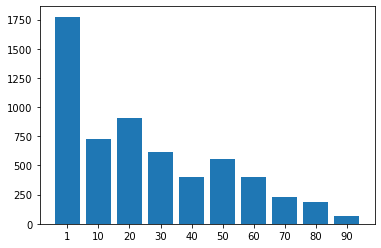

In [7]:
dict_train_face_age = {}

for age in ['1','10','20','30','40','50','60','70','80','90']:
    dict_train_face_age[age] = 0

for age in train_face_age['ClassId']:
    dict_train_face_age[age] += 1

plt.bar(dict_train_face_age.keys(), dict_train_face_age.values())

## 2. 데이터 전 처리

##### [assignment 1] train_datagen을 변경하여 학습해보기

train data와 validation data로 나눕니다. 이 과정에서 tensorflow.keras 패키지에서 제공하는 함수를 사용합니다. tf.keras.preprocessing.image.ImageDataGenerator는 기본적인 데이터 augmentation 기법을 제공합니다. 이미지 전처리 기법도 모델의 최종 성능을 높이는 좋은 방법입니다.

In [8]:
img_height = 128
img_width  = 128
batch_size = 32

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe   = train_face_age ,
        directory   = '.',
        x_col       = 'Path', 
        y_col       = 'ClassId',
        target_size = (img_height, img_width),
        batch_size  = batch_size,
        class_mode  = 'sparse')

val_generator = val_datagen.flow_from_dataframe(
        dataframe   = val_face_age,
        directory   = '.',
        x_col       = 'Path',
        y_col       = 'ClassId',
        target_size = (img_height, img_width),
        batch_size  = batch_size,
        class_mode  = 'sparse')

Found 5863 validated image filenames belonging to 10 classes.
Found 1955 validated image filenames belonging to 10 classes.


In [10]:
data_classes = train_generator.class_indices
num_classes = len(data_classes)
print('class: {}'.format(data_classes))

class: {'1': 0, '10': 1, '20': 2, '30': 3, '40': 4, '50': 5, '60': 6, '70': 7, '80': 8, '90': 9}


In [11]:
for image_batch, labels_batch in train_generator:
    print(labels_batch)
    break

[1. 1. 3. 1. 5. 3. 5. 0. 0. 1. 2. 0. 0. 2. 1. 2. 2. 5. 1. 8. 0. 5. 0. 6.
 0. 1. 0. 3. 3. 6. 3. 5.]


In [12]:
for image_batch, labels_batch in val_generator:
    print(labels_batch)
    break

[6. 2. 2. 0. 6. 0. 3. 3. 6. 3. 5. 0. 0. 4. 1. 2. 5. 5. 2. 6. 2. 3. 2. 0.
 1. 8. 8. 0. 3. 4. 7. 7.]


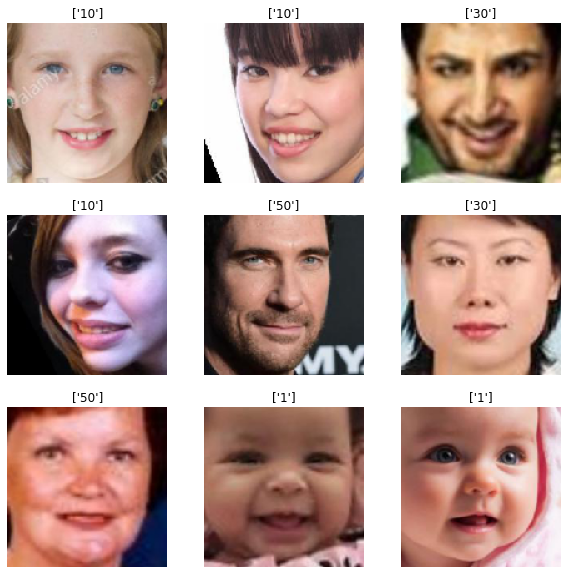

In [13]:
plt.figure(figsize=(10, 10))
images, labels = train_generator[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    key = [key for key, value in data_classes.items() if value  == labels[i]]
    plt.title(key)
    plt.axis("off")

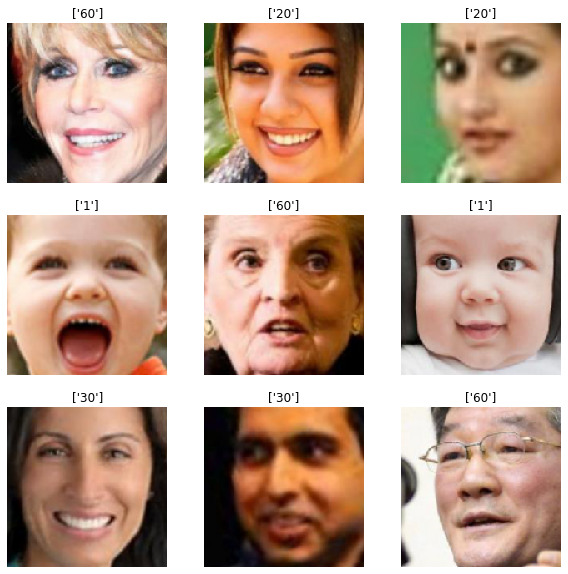

In [14]:
plt.figure(figsize=(10, 10))
images, labels = val_generator[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    key = [key for key, value in data_classes.items() if value  == labels[i]]
    plt.title(key)
    plt.axis("off")

## 3. Convolutional Neural Network (CNN) 모델

model.summary()는 모델의 구성을 한 눈에 확인할 수 있게 도와줍니다.

##### [assignment 2] 모델 구조를 수정해보기

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

##### [assignment 3] optimizer 변경해보기

### https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [16]:
epochs = 20

opt = tf.keras.optimizers.SGD(lr=0.001)

model.compile(optimizer=opt, #'adam' lr = default 0.01
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

학습 과정을 시각화하여 확인합니다. 학습이 진행되면서 loss는 줄고, accuracy는 올라가는 것을 확인할 수 있습니다.

In [17]:
print(model.layers[0].get_weights()) #before training

[array([[[[ 0.16076383, -0.06649634,  0.09313154, -0.04090096,
           0.12395483,  0.16517836,  0.02243865, -0.15693039,
           0.11748415,  0.1177721 ,  0.01386225,  0.10617152,
          -0.12284873,  0.07764643,  0.14662749, -0.17739624],
         [ 0.06651524,  0.02171275,  0.09478864,  0.14435095,
           0.08129191,  0.16560718,  0.08817515, -0.16781111,
           0.00718595,  0.1216636 ,  0.15500972, -0.03152891,
          -0.1154556 , -0.09600546,  0.03476928, -0.15778202],
         [ 0.18085796, -0.12748238,  0.05322972,  0.04811446,
          -0.07203122, -0.1493124 , -0.05834381,  0.09269813,
          -0.14707337,  0.15310296,  0.08526385, -0.11800738,
          -0.16408366,  0.06806448, -0.06178026, -0.09777413]],

        [[-0.17221108, -0.04313436, -0.14696223,  0.05652432,
           0.08738592, -0.18287829,  0.12435403, -0.04140526,
          -0.13155058,  0.18038228, -0.01689185,  0.03943723,
           0.18346208,  0.13787884, -0.14603843,  0.17379022],
 

In [18]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
#              tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]#,
#              #scheduler]

history = model.fit(
    x               = train_generator,      
    validation_data = val_generator,
    epochs          = epochs,
#     callbacks       = callbacks
)

Epoch 1/20
184/184 [==============================] - 47s 256ms/step - loss: 2.1153 - accuracy: 0.2858 - val_loss: 1.9722 - val_accuracy: 0.2900
Epoch 2/20
184/184 [==============================] - 46s 251ms/step - loss: 1.9564 - accuracy: 0.3055 - val_loss: 1.9227 - val_accuracy: 0.3217
Epoch 3/20
184/184 [==============================] - 46s 252ms/step - loss: 1.8938 - accuracy: 0.3534 - val_loss: 1.8574 - val_accuracy: 0.3678
Epoch 4/20
184/184 [==============================] - 46s 252ms/step - loss: 1.8420 - accuracy: 0.3701 - val_loss: 1.8020 - val_accuracy: 0.3780
Epoch 5/20
184/184 [==============================] - 46s 252ms/step - loss: 1.8161 - accuracy: 0.3780 - val_loss: 1.7675 - val_accuracy: 0.3841
Epoch 6/20
184/184 [==============================] - 47s 254ms/step - loss: 1.7702 - accuracy: 0.3839 - val_loss: 1.7045 - val_accuracy: 0.3908
Epoch 7/20
184/184 [==============================] - 47s 256ms/step - loss: 1.7229 - accuracy: 0.3971 - val_loss: 1.6794 - val_ac

학습 과정을 시각화하여 확인합니다. 학습이 진행되면서 loss는 줄고, accuracy는 올라가는 것을 확인할 수 있습니다.

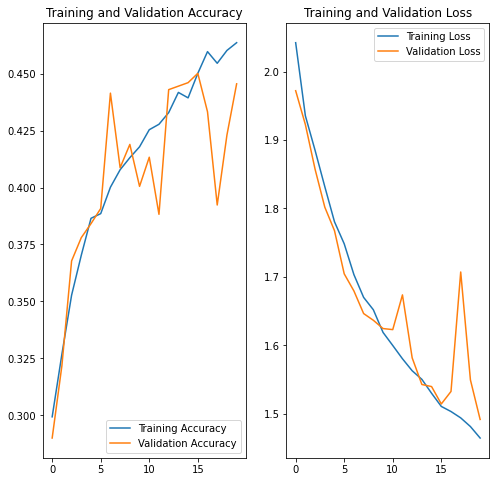

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

학습 후 weight. 학습 전 weight와 비교하여 달라졌음을 볼 수 있습니다. 즉, CNN이 학습되는 과정은 수많은 weigt를 학습하면서 모델이 예측에 필요한 feature를 사용할 수 있는 방향으로 업데이트된다는 것을 의미합니다.

In [20]:
print(model.layers[0].get_weights())

[array([[[[ 1.60652846e-01, -5.51261082e-02,  8.67267475e-02,
          -2.32854597e-02,  1.35878682e-01,  1.64823323e-01,
           4.79222499e-02, -1.35333210e-01,  1.28130645e-01,
           1.50264308e-01,  3.45983803e-02,  1.20580688e-01,
          -1.22846574e-01,  6.84197769e-02,  1.52016506e-01,
          -1.77388906e-01],
         [ 6.64057955e-02,  3.44625451e-02,  8.67990106e-02,
           1.69015974e-01,  8.97898301e-02,  1.65266529e-01,
           1.12726688e-01, -1.41865537e-01,  2.17052866e-02,
           1.54711559e-01,  1.75501242e-01, -2.02891678e-02,
          -1.15454212e-01, -1.04512826e-01,  3.98859791e-02,
          -1.57780901e-01],
         [ 1.80738181e-01, -1.16756290e-01,  4.80863266e-02,
           6.60560057e-02, -6.14592135e-02, -1.49703830e-01,
          -3.95287499e-02,  1.14516146e-01, -1.36598453e-01,
           1.77864373e-01,  1.01084881e-01, -1.09579355e-01,
          -1.64083093e-01,  6.38379455e-02, -5.83956614e-02,
          -9.77754965e-02]],

학습 과정을 재설계하기 위하여 결과를 분석합니다. 아래의 그림은 Confusion Matrix로, 세로 줄은 실제 값을, 가로 줄은 예측 값을 나타냅니다.

In [21]:
val_prediction = model.predict(val_generator)
prediction = np.argmax(val_prediction, axis = 1)

In [22]:
prediction

array([1, 0, 2, ..., 1, 1, 0])

<BarContainer object of 10 artists>

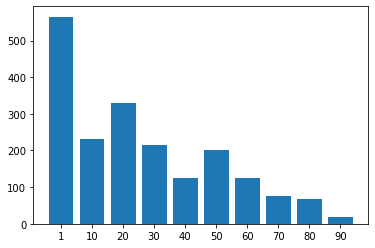

In [23]:
dict_val_face_age = {}

for age in ['1','10','20','30','40','50','60','70','80','90']:
    dict_val_face_age[age] = 0

for age in val_face_age['ClassId']:
    dict_val_face_age[age] += 1

plt.bar(dict_val_face_age.keys(), dict_val_face_age.values())

<AxesSubplot:>

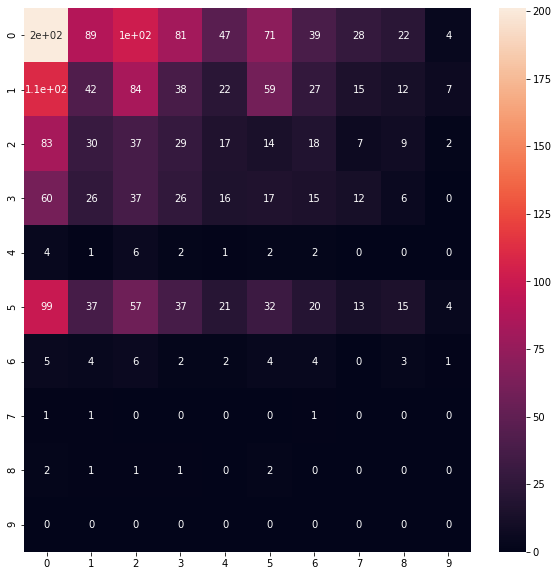

In [24]:
cm = confusion_matrix(prediction, val_generator.labels)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True)

In [25]:
cm

array([[201,  89, 102,  81,  47,  71,  39,  28,  22,   4],
       [110,  42,  84,  38,  22,  59,  27,  15,  12,   7],
       [ 83,  30,  37,  29,  17,  14,  18,   7,   9,   2],
       [ 60,  26,  37,  26,  16,  17,  15,  12,   6,   0],
       [  4,   1,   6,   2,   1,   2,   2,   0,   0,   0],
       [ 99,  37,  57,  37,  21,  32,  20,  13,  15,   4],
       [  5,   4,   6,   2,   2,   4,   4,   0,   3,   1],
       [  1,   1,   0,   0,   0,   0,   1,   0,   0,   0],
       [  2,   1,   1,   1,   0,   2,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

---

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>